In [1]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from utils import sparsify_beta

from postprocess_utils import *
import pandas as pd
import sqlalchemy

import h5py
from plotting_utils import *

In [2]:
from sklearn.preprocessing import StandardScaler

In [61]:
from sklearn.linear_model import LassoCV
from pyuoi import UoI_Lasso
from pyc_based.pycasso_cv import PycassoCV

In [4]:
# %load ../../loaders/datgen.py
n_features = 100
n_samples = 400

In [44]:
from utils import gen_covariance, gen_beta2, gen_data, calc_avg_cov

In [6]:
# First the uncorrelated case --> For sparsity 0.25 and betawidth -1, run each algorithm 
# 10 times

sigma = gen_covariance(n_features, 0, n_features, 1, 0)
beta = gen_beta2(n_features, n_features, sparsity = 0.25, betawidth = -1)

nreps = 10

lasso_beta_hat = np.zeros((nreps, n_features))
uoi_beta_hat = np.zeros((nreps, n_features))

for i in range(nreps):

    t0 = time.time()
    X, X_test, y, y_test, ss = gen_data(n_samples, n_features, kappa = 5, 
                                        covariance = sigma, beta = beta)
    
    # Standardize
    X = StandardScaler().fit_transform(X)
    y -= np.mean(y)
    
    lasso = LassoCV(fit_intercept=False, cv=5)
    lasso.fit(X, y.ravel())
    
    lasso_beta_hat[i, :] = lasso.coef_
    
    uoi = UoI_Lasso(fit_intercept=False, estimation_score='BIC')
    uoi.fit(X, y)
    uoi_beta_hat[i, :] = uoi.coef_
     
    print(time.time() - t0)

2.5119504928588867
2.210634231567383
2.8960394859313965
2.4102542400360107
2.7964141368865967
2.9449071884155273
2.5214858055114746
2.329519033432007
3.420111656188965
3.0945699214935303


In [11]:
# What is the average bias of lasso?
np.mean(np.linalg.norm(lasso_beta_hat - beta.ravel()))

13.76757933105431

In [12]:
# What is the average bias of UoI
np.mean(np.linalg.norm(uoi_beta_hat - beta.ravel()))

10.467397451774

In [59]:
# Restrict to the true model support
def reduced_bias(beta, beta_hat, flag='true', norm=None):
    
    if flag == None:
        
        bias = np.mean(np.linalg.norm(beta_hat - beta.ravel()))
    
    if flag == 'true':
        
        reduced_support = np.nonzero(beta)[0]

        bias = 0
        
        for i in range(beta_hat.shape[0]):

            bias += 1/beta_hat.shape[0] * np.linalg.norm(beta_hat[i, reduced_support]
                                                        - beta.ravel()[reduced_support])

    elif flag == 'common':
    
        bias = 0
    
        for i in range(beta_hat.shape[0]):
            
            b = beta
            bhat = beta_hat[i, :]
            
            common_support = list(set(list(np.nonzero(b)[0])).intersection(
                      set(list(np.nonzero(bhat)[0]))))

            bias += 1/beta_hat.shape[0] * np.linalg.norm(beta_hat[i, common_support]
                                                        - beta.ravel()[common_support])            
    return bias
            

In [26]:
from utils import get_cov_list, sparsify_beta

In [ ]:
cov_param['block_size']

KeyboardInterrupt: 

In [ ]:
#1 : Can we recover beta from sparsification with a seed?

In [43]:
for i1, cov_param in enumerate(cov_params):
    beta_ = sparsify_beta(beta, cov_param['block_size'], sparsity=0.25,
                          seed= cov_param['block_size'])
    try:
        assert(np.allclose(betas[i1, -1, :], beta_.ravel()))
    except:
        pdb.set_trace()

In [ ]:
avg_cov = np.array([calc_avg_cov(100, **cp) for cp in cov_params])
cov_order = np.argsort(avg_cov)

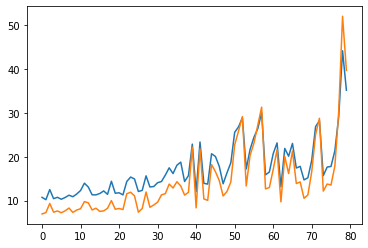

In [57]:
# seems to work fine
# Next step: How does the bias of UoI vs. Lasso change across correlation design

# total bias
lasso_bias = np.array([reduced_bias(betas[j, -1, :], lasso_beta_hat[j, ...], flag=None)
                       for j in range(len(cov_params))])
uoi_bias = np.array([reduced_bias(betas[j, -1, :], uoi_beta_hat[j, ...], flag=None)
                     for j in range(len(cov_params))])
plt.plot(lasso_bias[cov_order])
plt.plot(uoi_bias[cov_order])

In [45]:
beta.shape

(100, 1)

In [49]:
lasso_beta_hat.shape

(80, 10, 100)

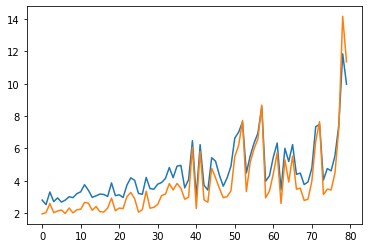

In [56]:
# true support bias
lasso_bias = np.array([reduced_bias(betas[j, -1, :], lasso_beta_hat[j, ...], flag='true')
                       for j in range(len(cov_params))])
uoi_bias = np.array([reduced_bias(betas[j, -1, :], uoi_beta_hat[j, ...], flag='true')
                     for j in range(len(cov_params))])
plt.plot(lasso_bias[cov_order])
plt.plot(uoi_bias[cov_order])

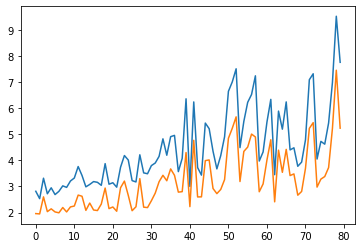

In [60]:
# Common support bias
lasso_bias = np.array([reduced_bias(betas[j, -1, :], lasso_beta_hat[j, ...], flag='common')
                       for j in range(len(cov_params))])
uoi_bias = np.array([reduced_bias(betas[j, -1, :], uoi_beta_hat[j, ...], flag='common')
                     for j in range(len(cov_params))])
plt.plot(lasso_bias[cov_order])
plt.plot(uoi_bias[cov_order])

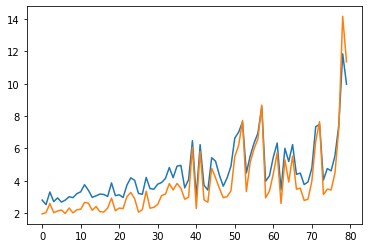

In [ ]:
# While we are at it, can we do SCAD?

In [65]:
# Does UoI take a lot longer with r2 estimation tahan BIC?
t0 = time.time()
uoi = UoI_Lasso(fit_intercept=False, estimation_score='BIC')
uoi.fit(X, y)
print(time.time() - t0)

t0 = time.time()
uoi = UoI_Lasso(fit_intercept=False, estimation_score='r2')
uoi.fit(X, y)
print(time.time() - t0)

1.763214349746704
1.8001470565795898
